In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy


In [2]:
m= 1/15000000 # map scale value
rho = 6371*1000 # radius of earth in meters
phi0 = 60 # phi naught  - intersecting plane at 60 deg North
lamb0 = 245 # 245 degrees longitude West


In [3]:
def getData(mydatapath):
    with open(mydatapath) as f:
        myfile = f.read().splitlines() #splits by newlines 
        
    myfile = [x.split(",") for x in myfile] # list of lines split be delimiter
    
    newArr = [None for x in range(len(myfile))] # index for station tracking
    floatArr = np.zeros((135,6),dtype='float') # floating point conversion
    # watch out for  floating point comparison as station ids are floats 
    for i in range(len(myfile)):
        # list of dictionaries. One dict for each station
        newArr[i] = { "Station":myfile[i][0],
                     "Latitude":myfile[i][1],
                     "Longitude":myfile[i][2],
                     "500mb Height":myfile[i][3],
                     "500mb Wind Direction":myfile[i][4],
                     "500mb Wind Speed": myfile[i][5] }  
        floatArr[i][0] = i # loop var same as station index
        floatArr[i][1:] = [float(x) for x in myfile[i][1:]] 
        # convert rest of items in sub-list  from str to float and pass it to array
    return floatArr

#==============================================================================
# this function converts our lats/lons of observations to x-y space
def ConvertMapCoords(coordArray: list,phi0=60,lamb0= 245): # preferably a numpy.ndarray

    radCoord = coordArray[:,1:3].copy()
    radCoord[:,1] = radCoord[:,1] - lamb0
    radCoord = radCoord * np.pi/180.0
    
    sigma = lambda phi,phi0=60: (1+np.sin(phi0 * np.pi/180)) / (1 + np.sin(phi)) 
    
    dataX = rho*sigma(radCoord[:,0]) * np.cos(radCoord[:,0])*np.cos(radCoord[:,1])
    dataY = rho*sigma(radCoord[:,0]) * np.cos(radCoord[:,0])*np.sin(radCoord[:,1])
    # transform data by map factor and then put into cm
    # WHY DID I DO NEGATIVE DATAY HERE?
    # it was because i reversed a formula lol. 
    return np.stack((coordArray[:,0],dataX,dataY,coordArray[:,3]),axis=1)

#==============================================================================
#this converts our x/y grid to map space. Input is in IMAGE PLANE METERS
def convertXYtoLatLon(xnew1,ynew1):
    xnew1 = np.copy(xnew1)
    ynew1 = np.copy(ynew1)
    mapX  = 245 + np.arctan(ynew1/xnew1)*180/np.pi # our xy grid in lat/lon space
    arg1 = np.power(((xnew1)**2 + (ynew1)**2),0.5)
    arg2 = (rho*(1+np.sin(phi0*np.pi/180.)))
    mapY = (np.pi/2 - 2*np.arctan(arg1/arg2))*180/np.pi

    return [mapX,mapY]

#==============================================================================
def makeMyGrid(X0=18.90,Y0=-6.30):
    
    #X0 = 18.90 #cm # x start value
    #Y0 = -6.30 #cm # y start value
    
    # input must be in radians. Fancy lamba functions!     
    # Creation of our analysis grid in x-y space
    #x_grid = np.linspace(X0,X0+1.27*21,22)
    #y_grid = np.linspace(Y0,Y0+1.27*27,28) # keeping in cm for now
    x_grid = 18.9 + np.arange(22)*1.27
    y_grid = -6.30 + np.arange(28)*1.27

    xnewO,ynewO = np.meshgrid(x_grid,y_grid) # this is our np.meshgrid
    xnewM = xnewO/100/m #convert to image plane
    ynewM = ynewO/100/m #convert to image plane
    return [xnewM,ynewM,xnewO,ynewO] # THIS WILL BE HUGE NUMBER IN METERS
    # O stands for Original cm, M stands for Meters
#==============================================================================
#==============================================================================
def getDminV3(stationMapSpace):
    stationMapSpace = np.copy(stationMapSpace) # since we're editing stuff
    stationList = stationMapSpace[:,1:3]*m*100 # we are in map space (cm) now
    distanceList = np.zeros(135)   

    for i in range(len(stationMapSpace)):
        arg = np.sqrt( (stationList[:,0] - stationList[i,0])**2 + \
                (stationList[:,1] - stationList[i,1])**2)
        this_min = np.min(arg[~np.isclose(arg,0.0)])
        distanceList[i] = this_min
            
    return np.mean(distanceList) # this is tne dmin distance in CENTIMETERS
#==============================================================================
def findCloseValues(xnew,ynew,stationMapSpace,dmin:float,dminScal:float):
    filteredDict = []
    stationMapSpace = np.copy(stationMapSpace) # since we're editing stuff
    stationMapSpace[:,1:3] = stationMapSpace[:,1:3]*m*100 # we are in map space (cm) now
    numObsInRadius = np.zeros((28,22))

    cressmanWeight = lambda dmin,scaler,dik:  \
        ( (dmin*scaler)**2 - dik**2) / (( (dmin*scaler) **2) + (dik**2)) 
        # fun with lambda functions! 
        
    for i in range(xnew.shape[0]):
        for j in range(xnew.shape[1]):
            #print(np.max(xnew),np.max(ynew))
            distanceFilter = np.sqrt( (xnew[i,j] - stationMapSpace[:,1])**2 + \
            (ynew[i,j] - stationMapSpace[:,2])**2)

            CressmanWeight = np.asarray([cressmanWeight(dmin,dminScal,x) for x in distanceFilter])
            CressmanWeight[distanceFilter > dmin*dminScal] = 0
            
            newArr = np.column_stack((stationMapSpace,CressmanWeight))
            # the weight is in the last column. it used CM
            obsCount = np.count_nonzero(CressmanWeight)
            numObsInRadius[i,j] = np.count_nonzero(CressmanWeight)
            
            filteredDict.append({"x":i,"y":j,"filteredObs":copy.deepcopy(newArr),"numObs":obsCount})
            
    # RETURN VALUE IS NOW IN CENTIMETERS SPACE!
    return [filteredDict,numObsInRadius]
#==============================================================================
def doCressmanPassOne(filteredDict,dmin,dminScal):
        
    arg = copy.deepcopy(filteredDict) # just to be safe, made a copy
    firstPass = np.zeros((28,22))
    
    for this_arg in arg:
        xc = this_arg['x']
        yc = this_arg['y']    
        this_pass = np.sum(this_arg['filteredObs'][:,-1]*this_arg['filteredObs'][:,-2]) / np.sum(this_arg['filteredObs'][:,-1])
        firstPass[xc,yc] = this_pass
        
        if this_arg["numObs"] == 0:
            #firstPass[xc,yc] = np.nan
            #TODO this is for values that have no  points in the ROI.
            print("darn!",xc,yc)
    return firstPass
def getRMSandFARK(xnew,ynew,filteredDict, previousPass,dmin,dminScal):
    #xnew and ynew should be in CM
    #this returns the analysis difference we use in updating fields. 
    cressmanWeight = lambda dmin,scaler,dik:  \
        ( (dmin*scaler)**2 - dik**2) / (((dmin*scaler) **2) + (dik**2)) 

    aInterp = [] # analysis interpolation
    for row in filteredDict[-1]['filteredObs']:
        pt = [row[1],row[2]]
        aInterp.append(doBilinearInterpolation(pt,previousPass))
        
    aInterp = np.asarray(aInterp)
    #print("BEFore",np.sum(np.isnan(aInterp)))

    #~~~
    # This block will to Cressman weights for the values that are outside of the 
    # grid and are returned as np.nan from the bilinear interpolation function]
    # Estimates the nan with a cressman function. recalculates the weights based
    # based on distance from that point. made a copy of filteredDict for safety. 
    # last column in each row is the weights as dthis_efined for analysis points. 
    
     #nanPlacesDict = copy.deepcopy(filteredDict)
    nanIndexes = np.where(np.isnan(aInterp))
    nanPlaces = filteredDict[-1]["filteredObs"][nanIndexes] # obs locations out of the 
     
    newCressmanOutBounds = np.zeros(nanPlaces.shape[0])
    for i in range(len(nanPlaces)):
         xc = nanPlaces[i,1]
         yc = nanPlaces[i,2]    
         #print(xc)
         nanDistanceFilter = np.sqrt( (xc - xnew)**2 + \
         ( yc - ynew)**2)

         nanCressmanWeightResult = np.asarray([cressmanWeight(dmin,dminScal,x) \
                                               for x in nanDistanceFilter])
             
         nanCressmanWeightResult[dmin*dminScal < nanDistanceFilter] = 0
         
         if  np.sum(nanCressmanWeightResult) != 0:
             this_location = np.sum(nanCressmanWeightResult*previousPass) / np.sum(nanCressmanWeightResult)
         # TODO - do out of location/bounds points improvement. 
         else:
             this_location = np.nan
         
         newCressmanOutBounds[i] = this_location
         if np.isnan(this_location):
             pass
    aInterp[np.isnan(aInterp)] = newCressmanOutBounds
     # this ends the section for finding the out of bound value interpolations

    #print("AFTER",np.sum(np.isnan(aInterp)))
    
    arg = copy.deepcopy(filteredDict) # just to be safe, made a copy
    farkMfork = arg[-5]['filteredObs'][:,-2][~np.isnan(aInterp)] - aInterp[~np.isnan(aInterp)]
    RMS = np.sqrt(np.nansum(farkMfork**2)/len(aInterp[~np.isnan(aInterp)]))
    print("RMS VALUE: ", RMS)
    
    return aInterp

def doSubsequentPasses(xnew,ynew,filteredDict, previousPass,aInterp,dmin,dminScal):
   #~~~~~~~~~~
    #[~np.isnan(aInterp)]
    arg = copy.deepcopy(filteredDict) # just to be safe, made a copy
    previousPass = copy.deepcopy(previousPass) # just to be safe, made another copy. 
    anotherPass = np.zeros((28,22))
    
    for this_arg in arg: 
        # this iterates through analyis points.
        #each analysis point has different weights.
        xc = this_arg['x']
        yc = this_arg['y']    
        w =  this_arg['filteredObs'][:,-1]
        
        # doing this over. could move out of loop. but keeping it here for now
        farkMfork = this_arg['filteredObs'][:,-2] - aInterp

        incr = np.nansum( (w*farkMfork)) / np.nansum(w)
        
        if this_arg["numObs"] != 0:
            anotherPass[xc,yc] = previousPass[xc,yc] + incr
        else:
            #print("no update to the increment here!")
            anotherPass[xc,yc] = previousPass[xc,yc]

    return anotherPass
#==============================================================================
#==============================================================================    
def doBilinearInterpolation(pt,wxField):
    # Lower Right, Upper Right, Upper Left, Lower Left, point
    # each of these is a numpy array of size 2, i.e. [x,y,z]. x/y/z are floats
    # x/y are the coords, and z is the value. 
    
    xgrid = 18.9 + np.arange(22)*1.27
    ygrid = -6.30 + np.arange(28)*1.27
    
    xcord = pt[0]
    ycord = pt[1]
    
        # this gives the INDEX of the things. 
    x1 = int(np.floor( (xcord - 18.9) / 1.27))
    x2 = int(np.ceil( (xcord - 18.9) / 1.27) )
    y1 = int(np.floor( (ycord - -6.30) / 1.27))
    y2 = int(np.ceil( (ycord - -6.30) / 1.27))
    
    if (pt[0] <18.9 or pt[0] > xgrid[-1] or pt[1] <-6.30 or pt[1] > ygrid[-1]):
        #print("darn, out of bounds")
        return np.nan
    # this gives the INDEX of the things. 
    x1 = int(np.floor( (xcord - 18.9) / 1.27))
    x2 = int(np.ceil( (xcord - 18.9) / 1.27) )
    y1 = int(np.floor( (ycord - -6.30) / 1.27))
    y2 = int(np.ceil( (ycord - -6.30) / 1.27))
    
    LL = [xgrid[x1],ygrid[y1],wxField.T[x1,y1]]
    LR = [xgrid[x2],ygrid[y1],wxField.T[x2,y1]]
    UL = [xgrid[x1],ygrid[y2],wxField.T[x1,y2]]
    UR = [xgrid[x2],ygrid[y2],wxField.T[x2,y2]]
    
    x1 = LL[0]
    x2 = LR[0]
    y1 = LL[1]
    y2 = UL[1]
     
    leftMatrix = np.matrix([ [1, x1, y1, x1*y1],
                 [1, x1, y2, x1*y2],
                 [1, x2, y1, x2*y1],
                 [1, x2 ,y2, x2*y2]])
    rightSide = np.matrix( [LL[2],UL[2],LR[2],UR[2] ] ).T
    leftMatrixInv = np.linalg.inv(leftMatrix)
    myArgs = leftMatrixInv @ rightSide
    ptArg = np.matrix( [ 1, pt[0],pt[1],pt[0]*pt[1] ] )
    result = ptArg @ myArgs
    numResult = result[0,0]
    #print("done")
    return numResult
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def getAnalysisDifferences(first,second,third):
    
    f2mf1 = second - first
    f3mf1 = third - first
    f3mf2 = third - second
    
    return {"secondMfirst": f2mf1, "thirdMfirst":f3mf1, "thirdMsecond":f3mf2}
#==============================================================================
#==============================================================================
def AnalysisFile(filterDict,xnewCM,ynewCM,mapX,mapY,numObs,FinalAnalysisFile,
                 dmin,dminScaler,PassNum:int,delim=","):
    header = ["i-index (unitless)","j-index (unitless)",
              "X-value (cm)","Y-value (cm)","Longitude (deg)", 
              "Latitude (deg)","Observation in Radius (count)",
              "500mb Height Analysis (m)","dmin (~2.55)","dminScaler"]
    
    header = delim.join([str(x) for x in header])    
    
    # MAKE SURE THAT I AM WRITING ANALYSIS DIFFERENCES IN THE RIGHT WAY. 
    # MAKE SURE THAT IT IS FLATTENED IN THE RIGHT WAY. 
    logfile = []
    logfile.append(header)
    for i in range(len(filterDict)):
        thisrow = [0,0,0,0,0,0,0,0,0,0]
        
        tester = filterDict[i]
        if len(tester["filteredObs"]) == 0:
            #print("temp")
            pass
            #continue
        mypoint = [tester["x"], tester["y"] ]
        thisrow[0] = tester["x"]
        thisrow[1] = tester["y"]
        thisrow[2] = np.round(xnewCM[ tester["x"], tester["y"]],4)
        thisrow[3] = np.round( ynewCM[ tester["x"], tester["y"]],4)
        thisrow[4] = np.round(mapX[tester["x"], tester["y"]],4)
        thisrow[5] = np.round(mapY[tester["x"], tester["y"]],4)
        thisrow[6] = np.round(tester["numObs"],4)
        thisrow[7] = np.round(FinalAnalysisFile[tester["x"], tester["y"]],4)
        thisrow[8] = np.round(dmin,4)
        thisrow[9] = np.round(dminScaler,4)
        
        # delimiter is just a comma
        arg = delim.join([str(x) for x in thisrow])
        logfile.append(arg)
        
    logfile = "\n".join(logfile)
    newFilename = "Analysis" + "Pass" + str(PassNum) + ".csv"
    with open(newFilename, "w") as fileToWrite:
        fileToWrite.write(logfile)
        
    return [logfile,newFilename]

def writeAnalyisDifference(filterDict,xnewCM,ynewCM,mapX,mapY,
                           analy1,analy2,thisDiff,diffLabel:str,delim=","):
    #print(analy2.keys())
    header = ["i-index (unitless)","j-index (unitless)",
              "X-value (cm)","Y-value (cm)","Longitude (deg)","Latitude (deg)",
              analy1["Label"],analy2["Label"],diffLabel +" (m)"]
    
    header = delim.join([str(x) for x in header])    
    
    # MAKE SURE THAT I AM WRITING ANALYSIS DIFFERENCES IN THE RIGHT WAY. 
    # MAKE SURE THAT IT IS FLATTENED IN THE RIGHT WAY. 
    logfile = []
    logfile.append(header)
    for i in range(len(filterDict)):
        thisrow = [0,0,0,0,0,0,0,0,0]
        
        tester = filterDict[i]
        if len(tester["filteredObs"]) == 0:
            #print("temp")
            pass
            #continue
        mypoint = [tester["x"], tester["y"] ]
        thisrow[0] = tester["x"]
        thisrow[1] = tester["y"]
        thisrow[2] = np.round(xnewCM[ tester["x"], tester["y"]],4)
        thisrow[3] = np.round( ynewCM[ tester["x"], tester["y"]],4)
        thisrow[4] = np.round(mapX[tester["x"], tester["y"]],4)
        thisrow[5] = np.round(mapY[tester["x"], tester["y"]],4)
        thisrow[6] = np.round(analy1["data"][tester["x"], tester["y"]],4)
        thisrow[7] = np.round(analy2["data"][tester["x"], tester["y"]],4)
        thisrow[8] = np.round(thisDiff[tester["x"], tester["y"]],4)

        
        # delimiter is just a comma
        arg = delim.join([str(x) for x in thisrow])
        logfile.append(arg)
        
    logfile = "\n".join(logfile)
    newFilename = "Analysis" + "Pass" + str(diffLabel) + ".csv"
    with open(newFilename, "w") as fileToWrite:
        fileToWrite.write(logfile)
        
    return [logfile,newFilename]
#~~~~~~~~~~~~~~~~~~~
def RegularPlotter(field,figTitle:str,ROIScaler:int,isRegular:bool):
    
    plt.clf()
    
    ax = plt.axes( projection=ccrs.NorthPolarStereo(central_longitude=245))
    ax.gridlines()
    
    if isRegular:
        levels = np.arange(5280,6060,60)
    
        thisContour = ax.contour(mapX,mapY,field, 
                levels = levels,transform=ccrs.PlateCarree(),zorder=2,colors="r")
        plt.title(figTitle + "\n ROI: " + str(ROIScaler) + "*dmin(dmin ~ 2.55)")
    else:
        thisContour = ax.contour(mapX,mapY,field, 
                transform=ccrs.PlateCarree(),zorder=2,colors="r")
        plt.title(figTitle) 
    ax.clabel(thisContour, inline=True, fontsize=10,colors="r")

    ax.coastlines("10m", alpha=1, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    state_borders = cfeature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lakes',
                               scale='50m', facecolor='None',linestyle='--',
                               linewidth=0.75)
    ax.add_feature(state_borders, edgecolor='black')
    plt.show()


In [4]:
mydatapath = "RAOBs_201903131200.txt"
floatArr = getData(mydatapath)
stationInMapSpace = ConvertMapCoords(floatArr) # we are in image space now. NOT MAP SPACE
xnewIM,ynewIM,xnewCM,ynewCM = makeMyGrid() #IM means meter image space, cm=cm
mapX,mapY = convertXYtoLatLon(xnewIM,ynewIM)
dmin = getDminV3(stationInMapSpace)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~
filteredDictCM, numObsinRadius1 = findCloseValues(xnewCM, 
                                 ynewCM, stationInMapSpace, dmin,4)

firstPass = doCressmanPassOne(filteredDictCM,dmin,4)

aInterp1 = getRMSandFARK(xnewCM,ynewCM,filteredDictCM,firstPass,dmin,4)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
filteredDictCM2, numObsinRadius2 = findCloseValues(xnewCM, 
                                 ynewCM, stationInMapSpace, dmin,2.5)

secondPass = doSubsequentPasses(xnewCM, ynewCM,
                                filteredDictCM2, 
                                firstPass, aInterp1, dmin, 2.5)

aInterp2 = getRMSandFARK(xnewCM,ynewCM,filteredDictCM2,secondPass,dmin,2.5)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
filteredDictCM3, numObsinRadius3 = findCloseValues(xnewCM, 
                                 ynewCM, stationInMapSpace, dmin,1.5)

thirdPass = doSubsequentPasses(xnewCM, ynewCM,
                                filteredDictCM3, 
                                secondPass, aInterp2, dmin, 1.5)

aInterp3 = getRMSandFARK(xnewCM,ynewCM,filteredDictCM3,thirdPass,dmin,1.5)
#print(aInterp3)

RMS VALUE:  74.07880556074385
RMS VALUE:  34.00580590913828
RMS VALUE:  13.231240095958885


C:\Users\joseph.gufford\AppData\Local\Temp\ipykernel_16376\1737000014.py:206: RuntimeWarning: invalid value encountered in scalar divide
  incr = np.nansum( (w*farkMfork)) / np.nansum(w)


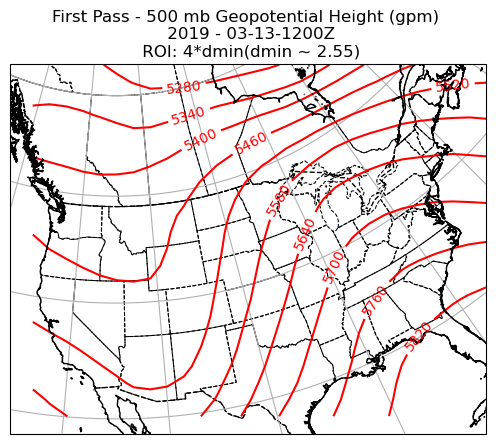

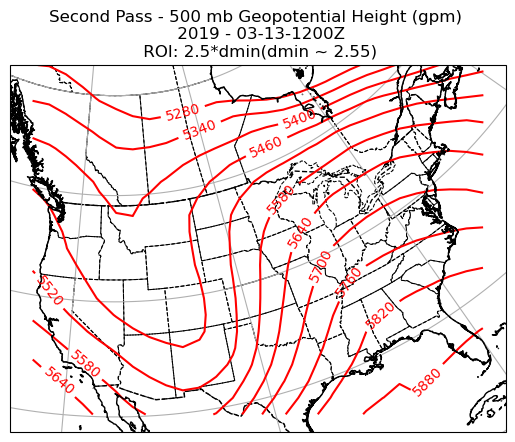

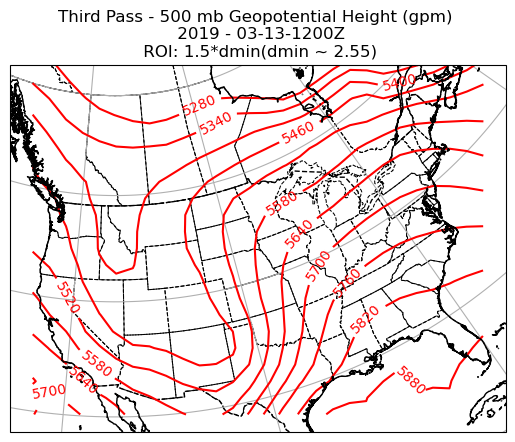

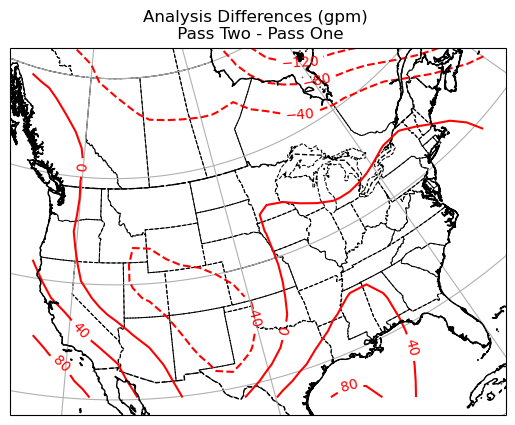

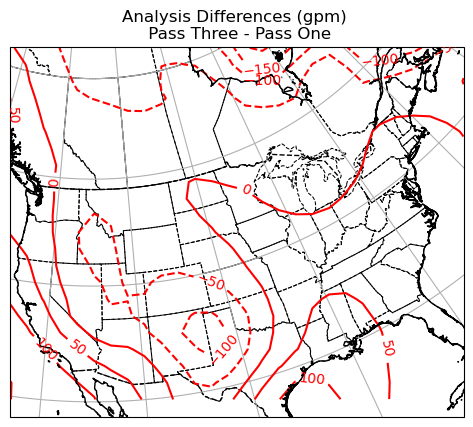

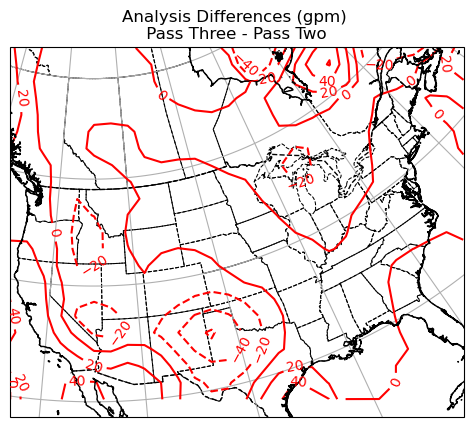

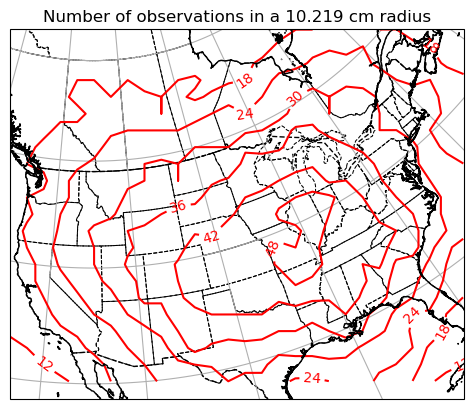

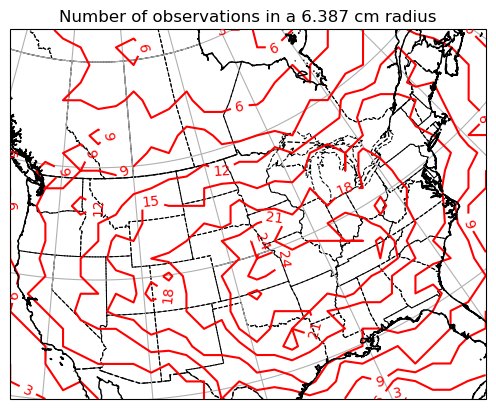

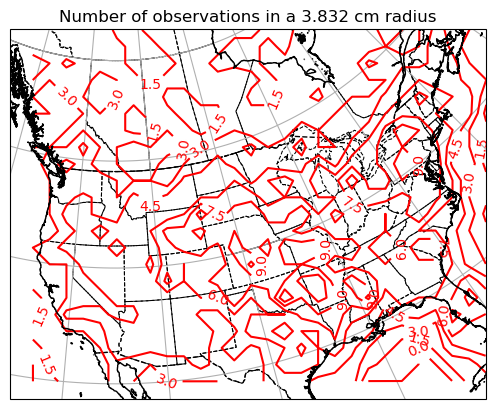

In [5]:
AnalysisFile(filteredDictCM,xnewCM,ynewCM,mapX,mapY,numObsinRadius1,firstPass,dmin,
             4,"OneJOE",",")

AnalysisFile(filteredDictCM2,xnewCM,ynewCM,mapX,mapY,numObsinRadius2,secondPass,dmin,
             2.5,"TwoJOE",",")

AnalysisFile(filteredDictCM3,xnewCM,ynewCM,mapX,mapY,numObsinRadius3,thirdPass,dmin,
             1.5,"ThreeJOE",",")

AnalysisDifferences = getAnalysisDifferences(firstPass, secondPass, thirdPass)

firstPassDict = {"Label":"First Pass (m)","data": firstPass}
secondPassDict = {"Label":"Second Pass (m)","data": secondPass}
thirdPassDict = {"Label": "Third Pass (m)","data":thirdPass}

writeAnalyisDifference(filteredDictCM, xnewCM, ynewCM, mapX, mapY, firstPassDict,
                       secondPassDict, AnalysisDifferences["secondMfirst"], "Pass_2_minus_Pass_1 (m) joe")

writeAnalyisDifference(filteredDictCM, xnewCM, ynewCM, mapX, mapY, firstPassDict,
                       thirdPassDict, AnalysisDifferences["thirdMfirst"], "Pass_3_minus_Pass_1 (m) joe")

writeAnalyisDifference(filteredDictCM, xnewCM, ynewCM, mapX, mapY, secondPassDict,
                       thirdPassDict, AnalysisDifferences["thirdMsecond"], "Pass_3_minus_Pass_Two (m) joe")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RegularPlotter(firstPass,"First Pass - 500 mb Geopotential Height (gpm) \n 2019 - 03-13-1200Z",4,True)
RegularPlotter(secondPass,"Second Pass - 500 mb Geopotential Height (gpm) \n 2019 - 03-13-1200Z",2.5,True)
RegularPlotter(thirdPass,"Third Pass - 500 mb Geopotential Height (gpm) \n 2019 - 03-13-1200Z",1.5,True)

RegularPlotter(AnalysisDifferences['secondMfirst'],"Analysis Differences (gpm) \n Pass Two - Pass One",0,False)
RegularPlotter(AnalysisDifferences['thirdMfirst'],"Analysis Differences (gpm) \n Pass Three - Pass One",0,False)
RegularPlotter(AnalysisDifferences['thirdMsecond'],"Analysis Differences (gpm) \n Pass Three - Pass Two ",0,False)

dmin1 = str(np.round(dmin*4,3))
dmin2 = str(np.round(dmin*2.5,3))
dmin3 = str(np.round(dmin*1.5,3))
RegularPlotter(numObsinRadius1,f"Number of observations in a {dmin1} cm radius",4,False)
RegularPlotter(numObsinRadius2,f"Number of observations in a {dmin2} cm radius",2.5,False)
RegularPlotter(numObsinRadius3,f"Number of observations in a {dmin3} cm radius",1.5,False)


In [6]:
# Writeup
'''
NOTE: The number of points considered in each ROI for each pass is stored in the AnalysisPassOne.csv, AnalysisPassTwo.csv, and AnalysisPassThree.csv
1. A negatively tilted longwave trough is present in the analyses. 
Sharp geopotential height gradients are present over the eastern half of the United States. 
Higher geopotential heights are seen over the eastern half of the United States. The flow is somewhat more zonal in Canada
at the northern periphery of the domain.
Otherwise, the flow has a strong meridional component over the central United States. 

2. The first pass (background) has weaker geopotential height gradients. The trough/ridge pattern in the background is of a weaker latitudinal amplitude.
The minimum pressures in the trough are also weaker. The 540 line is in Canada in the first pass, while it is in Idaho in the third pass. 
The first pass is quite smooth compared to the second and third passes. 
The smoother analysis is due to the greater number of stations included in the larger Radius of Influence. Subsequent analyses use an increment
that uses a smaller radius of influence. This allows smaller wavelength features to be resolved into the analysis. An example of this is the shortwave
over Idaho in Pass 2 and Pass 3. There are more slight kinks in the isobars seen in the third analysis, for example. 
The geopotential height gradients are much stronger in pass 2 and pass 3. 

3. As you increase the number of corrections, the analysis incorporates shorter wavelength features present in the atmosphere. It also increases the
geopotential height gradients. These attributes are desirable if shorter wavelength features are desired in the Analysis. The third analysis pass suffers near the edges
of the domain (see Florida and Baja California) due to the limited number of points nearby). 
'''

'\nNOTE: The number of points considered in each ROI for each pass is stored in the AnalysisPassOne.csv, AnalysisPassTwo.csv, and AnalysisPassThree.csv\n1. A negatively tilted longwave trough is present in the analyses. \nSharp geopotential height gradients are present over the eastern half of the United States. \nHigher geopotential heights are seen over the eastern half of the United States. The slow is somewhat more zonal in Canada\nat the northern periphery of the domain.\nOtherwise, the flow has a strong meridional component over the central United States. \n\n2. The first pass (background) has weaker geopotential height gradients. The trough/ridge pattern in the background is of a weaker latitudinal amplitude.\nThe minimum pressures in the trough are also weaker. The 540 line is in Canada in the first pass, while it is in Idaho in the third pass. \nThe first pass is quite smooth compared to the second and third passes. \nThe smoother analysis is due to the greater number of stati